## 1. Load Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Read Data

I am using Sumer Sports' 2024 quarterback dataset from their player statistics dashboard. This data is compiled by Sumer Sports and publicly available online for free. This dataset contains 77 observations with 18 features. Columns including counting stats and expected stats.

In [12]:
df = pd.read_csv("2024_nfl_qb.csv")

## 3. Define Features and Target

For feature selection, I am choosing a variety of features that would likely have some effect on QB Expected Points Added, which is my target. I am using my existing knowledge of football and football analytics to figure out which features I should be using. 

Ultimately, I selected the following seven features to predict Total EPA. Most of these features are statistics that indicate a quarterback's ability to extend plays, score points, and limit turnovers.

In [29]:
features = ['Scramble %', 'Sack %', 'ADoT', 'Pass Yards', 'Pass TD', 'INT', 'YPA']
target = 'Total EPA'

## 4. Clean Data

Adjusts percentages to decimals to work with model.

In [14]:
percent_cols = ['Scramble %', 'ADoT', 'Sack %']
for col in percent_cols:
    if df[col].dtype == object:
        df[col] = df[col].str.rstrip('%').astype(float) / 100

for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[target] = pd.to_numeric(df[target], errors='coerce')

df = df.dropna(subset=features + [target])

## 5. Prepare Model and Train/Test

In [15]:
X = df[features].values
y = df[target].values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)


## 6. Fit Random Forest

In [16]:
rf = RandomForestRegressor(n_estimators=25, max_depth=4, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=25, random_state=42)

## 7. Predict

In [17]:
y_pred = rf.predict(X_test)

## 8. Evaluate

In [23]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r = r2 ** (1/2)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R: {r:.2f}")
print(f"R^2: {r2:.2f}")

RMSE: 28.75
MAE: 15.46
R: 0.88
R^2: 0.77


My RMSE of 28.75 leaves room for improvement, but I feel better about my model given the 0.77 R^2 score and 0.88 R score.

The R^2 value of 0.77 means that 77% of the variation in EPA among quarterbacks can be explained by the model's input features.

## 9. Visualization

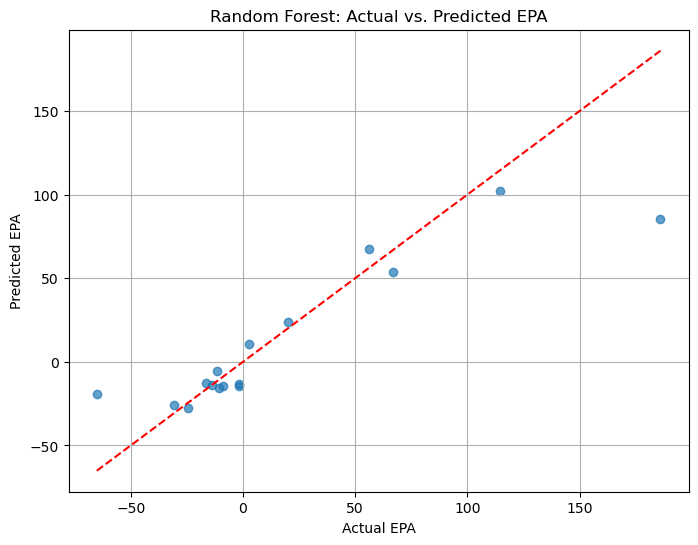

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual EPA")
plt.ylabel("Predicted EPA")
plt.title("Random Forest: Actual vs. Predicted EPA")
plt.grid(True)
plt.show()

This scatterplot compares actual Total EPA to the predictions from my random forest model. Included within the plot is a line of best fit (dashed red line) which shows a perfect fit of actual vs. predicted. In other words, if every EPA total was predicted correctly by the decision tree model, every blue plotted point would fall exactly along the red dashed line.

For the most part, I am pleased with the relationship between actual and predicted EPA. I only notice a few points straying from the line, and one extreme outlier. 

## 10. Residuals

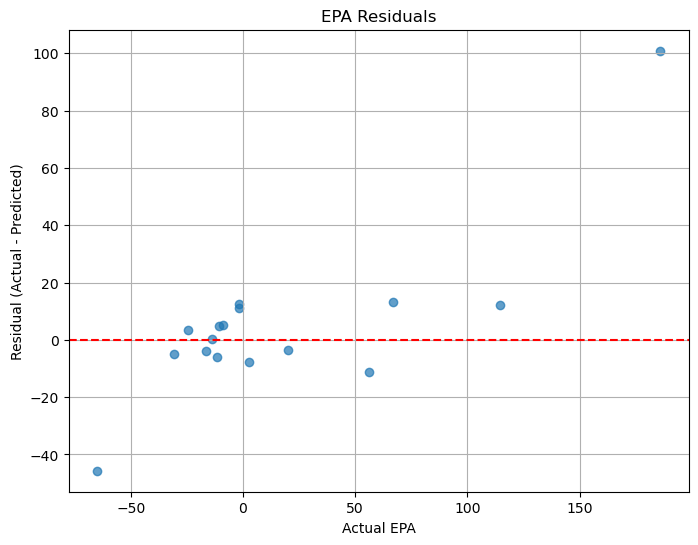

In [27]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual EPA")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("EPA Residuals")
plt.grid(True)
plt.show()

The above visual shows the residuals for my exploration into EPA totals. In other words, it plots the difference between actual and predicted EPA totals among NFL quarterbacks. I am satisfied that this plot shows the residuals randomly scattered around 0, as desired. There are only two extreme outliers observed.

## 11. Performance Evaluation

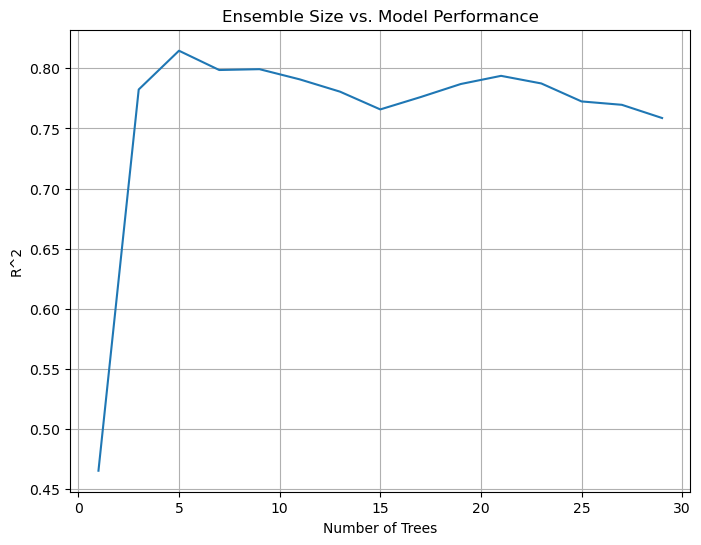

In [28]:
tree_counts = list(range(1, 31, 2))
r2_scores = []

for n in tree_counts:
    model = RandomForestRegressor(n_estimators=n, max_depth=4, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2_scores.append(r2_score(y_test, preds))

plt.figure(figsize=(8, 6))
plt.plot(tree_counts, r2_scores)
plt.xlabel("Number of Trees")
plt.ylabel("R^2")
plt.title("Ensemble Size vs. Model Performance")
plt.grid(True)
plt.show()

This plot tracks the random forest model’s R^2 score as the number of trees increases. The R^2 score peaks around 5 trees, after which performance plateaus or slightly declines. This suggests that a small number of trees is sufficient to capture the predictive power of the features, and adding more trees may result in slight overfitting. 